In [1]:
%reset -f

In [2]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import pickle


## I. Analyse de la base de données

La base de données est sous format JSON. Nous allons la transformer dans un format DataFrame en conservant la partie "text" et la partie "Intent"

In [3]:
with open('data.json') as file:
    data = json.load(file)

training_labels = []
training_sentences = []
responses = []
labels = []

## We transform JSON into dataframe
for intent in data['intents']:
    for text in intent['text']:
            training_sentences.append(text)
            training_labels.append(intent['intent'])
    responses.append(intent['responses'])

for label in training_labels:
    if label not in labels:
        labels.append(label)
        
len_labels = len(labels)

df = pd.DataFrame(list(zip(training_sentences,training_labels)),columns = ['Text','Intent'])
df

,Text,Intent
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting
...,...,...
138,Can you prove you have a conscious,SelfAware
139,Can you prove you are self-aware please,SelfAware
140,Can you prove you are self aware please,SelfAware
141,Can you prove you have a conscious please,SelfAware


Afin d'avoir une visualisation globale des intentions présentes, nous affichons un workcloud

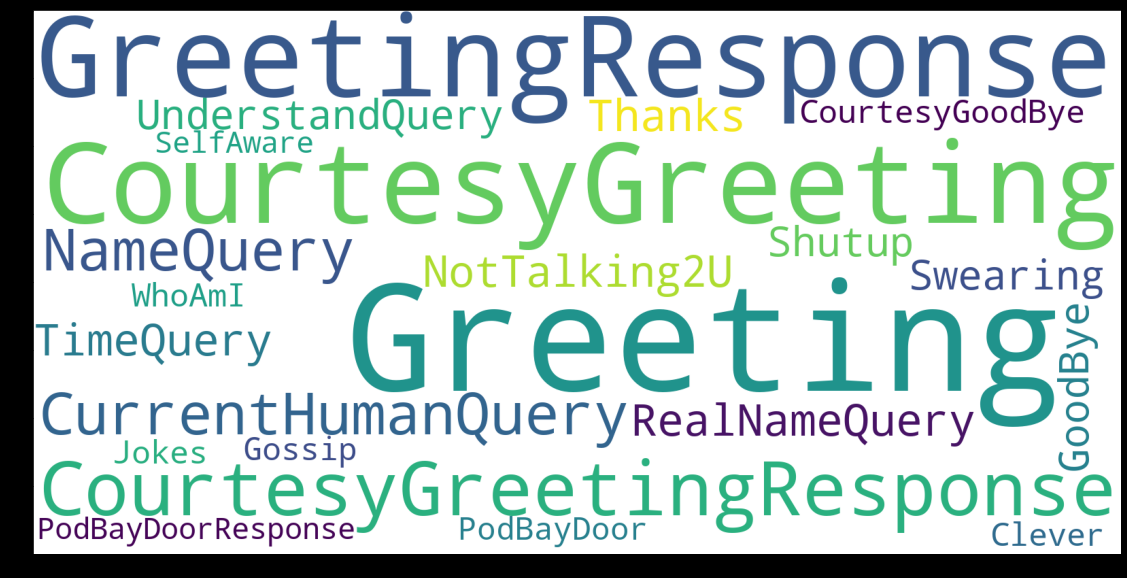

In [4]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(labels))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

Enfin nous allons encoder nos labels avec le label encodeur

In [5]:
label_enc = LabelEncoder()
df['Intent'] = label_enc.fit_transform(df['Intent'])
df

,Text,Intent
0,Hi,7
1,Hi there,7
2,Hola,7
3,Hello,7
4,Hello there,7
...,...,...
138,Can you prove you have a conscious,15
139,Can you prove you are self-aware please,15
140,Can you prove you are self aware please,15
141,Can you prove you have a conscious please,15


### Pre - Processing

Nous appliquons ici tout le pré-processing nécessaire grâce à la classe Tokenizer()

In [6]:
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = None,oov_token = oov_token)
tokenizer.fit_on_texts(df["Text"])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df["Text"])
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)
intent_array = df["Intent"].values

In [7]:
print('input shape: {} and output shape: {}'.format(padded_sequences.shape, intent_array.shape))

input shape: (143, 20) and output shape: (143,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, intent_array, test_size=0.2, random_state=42)

In [9]:
## List that contains all accuracies
list_acc = []

## 1er modèle de réseau de neurones

In [10]:
# hyperparameters
epochs=150
target_length=len_labels

In [11]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(GlobalAveragePooling1D())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(target_length, activation='softmax'))

model1.compile(loss='sparse_categorical_crossentropy',  metrics=['accuracy'])
model1.summary()

2022-05-04 19:25:09.628405: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 22)                1430      
                                                                 
Total params: 22,678
Trainable params: 22,678
Non-trainable params: 0
____________________________________________________

In [12]:
history = model1.fit(X_train,y_train , validation_data = (X_test,y_test), epochs=epochs,batch_size=5, verbose=1)

Epoch 1/150
23/23 [==============================] - 1s 16ms/step - loss: 3.0950 - accuracy: 0.0439 - val_loss: 3.0948 - val_accuracy: 0.0690
Epoch 2/150
23/23 [==============================] - 0s 3ms/step - loss: 3.0898 - accuracy: 0.0614 - val_loss: 3.0979 - val_accuracy: 0.1034
Epoch 3/150
23/23 [==============================] - 0s 3ms/step - loss: 3.0866 - accuracy: 0.0526 - val_loss: 3.1018 - val_accuracy: 0.0690
Epoch 4/150
23/23 [==============================] - 0s 4ms/step - loss: 3.0841 - accuracy: 0.1140 - val_loss: 3.1047 - val_accuracy: 0.0690
Epoch 5/150
23/23 [==============================] - 0s 2ms/step - loss: 3.0794 - accuracy: 0.1404 - val_loss: 3.1059 - val_accuracy: 0.0690
Epoch 6/150
23/23 [==============================] - 0s 3ms/step - loss: 3.0742 - accuracy: 0.1404 - val_loss: 3.1093 - val_accuracy: 0.1034
Epoch 7/150
23/23 [==============================] - 0s 2ms/step - loss: 3.0671 - accuracy: 0.1579 - val_loss: 3.1117 - val_accuracy: 0.1034
Epoch 8/150


Epoch 59/150
23/23 [==============================] - 0s 5ms/step - loss: 1.2764 - accuracy: 0.5877 - val_loss: 2.5843 - val_accuracy: 0.4483
Epoch 60/150
23/23 [==============================] - 0s 5ms/step - loss: 1.2620 - accuracy: 0.5789 - val_loss: 2.6236 - val_accuracy: 0.4483
Epoch 61/150
23/23 [==============================] - 0s 2ms/step - loss: 1.2375 - accuracy: 0.5702 - val_loss: 2.6158 - val_accuracy: 0.4828
Epoch 62/150
23/23 [==============================] - 0s 2ms/step - loss: 1.2122 - accuracy: 0.5877 - val_loss: 2.6435 - val_accuracy: 0.5172
Epoch 63/150
23/23 [==============================] - 0s 3ms/step - loss: 1.1919 - accuracy: 0.5702 - val_loss: 2.6468 - val_accuracy: 0.4483
Epoch 64/150
23/23 [==============================] - 0s 2ms/step - loss: 1.1685 - accuracy: 0.5789 - val_loss: 2.5996 - val_accuracy: 0.5172
Epoch 65/150
23/23 [==============================] - 0s 2ms/step - loss: 1.1489 - accuracy: 0.6404 - val_loss: 2.7377 - val_accuracy: 0.4483
Epoch 

23/23 [==============================] - 0s 4ms/step - loss: 0.4065 - accuracy: 0.9035 - val_loss: 3.4630 - val_accuracy: 0.5517
Epoch 117/150
23/23 [==============================] - 0s 5ms/step - loss: 0.3935 - accuracy: 0.9211 - val_loss: 3.5224 - val_accuracy: 0.5517
Epoch 118/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3896 - accuracy: 0.9211 - val_loss: 3.5130 - val_accuracy: 0.5172
Epoch 119/150
23/23 [==============================] - 0s 6ms/step - loss: 0.3764 - accuracy: 0.8947 - val_loss: 3.6501 - val_accuracy: 0.4828
Epoch 120/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3634 - accuracy: 0.9474 - val_loss: 3.6097 - val_accuracy: 0.5172
Epoch 121/150
23/23 [==============================] - 0s 4ms/step - loss: 0.3573 - accuracy: 0.9561 - val_loss: 3.6183 - val_accuracy: 0.5517
Epoch 122/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3454 - accuracy: 0.9211 - val_loss: 3.5649 - val_accuracy: 0.5517
Epoch 123/150

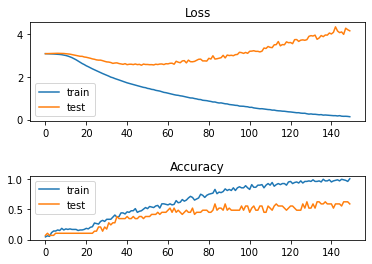

In [13]:
plot1 = plt.subplot2grid((2, 1), (0, 0), colspan=1)
plot2 = plt.subplot2grid((3, 1), (2, 0), colspan=2)


# plot loss during training
plot1.set_title('Loss')
plot1.plot(history.history['loss'], label='train')
plot1.plot(history.history['val_loss'], label='test')
plot1.legend()



# plot accuracy during training
plot2.set_title('Accuracy')
plot2.plot(history.history['accuracy'], label='train')
plot2.plot(history.history['val_accuracy'], label='test')
plot2.legend()

In [14]:
acc = model1.evaluate(X_test,y_test)[1]

print(" The accuracy of the model one is", acc)

list_acc.append(acc)

1/1 [==============================] - 0s 26ms/step - loss: 4.1680 - accuracy: 0.5862
 The accuracy of the model one is 0.5862069129943848


## 2e modèle de réseaux de neurones

In [15]:
# hyperparameters
epochs=30
vocab_size=len(tokenizer.word_index) + 1
embed_dim=512
units=128
target_length=len_labels

In [16]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, dropout=0.2)),
    tf.keras.layers.Dense(units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_length, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-2)
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          1888      
                                                                 
 bidirectional (Bidirectiona  (None, 256)              148480    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 22)                2838      
                                                                 
Total params: 186,102
Trainable params: 186,102
Non-trainable params: 0
________________________________________________

/opt/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
history = model2.fit(X_train,y_train ,validation_data = (X_test,y_test), epochs=epochs)

Epoch 1/30
4/4 [==============================] - 4s 304ms/step - loss: 3.1041 - accuracy: 0.0351 - val_loss: 3.0904 - val_accuracy: 0.0345
Epoch 2/30
4/4 [==============================] - 0s 34ms/step - loss: 3.0953 - accuracy: 0.0614 - val_loss: 3.1198 - val_accuracy: 0.0000e+00
Epoch 3/30
4/4 [==============================] - 0s 39ms/step - loss: 3.0615 - accuracy: 0.1053 - val_loss: 3.1359 - val_accuracy: 0.0000e+00
Epoch 4/30
4/4 [==============================] - 0s 61ms/step - loss: 3.0509 - accuracy: 0.0877 - val_loss: 3.0977 - val_accuracy: 0.0000e+00
Epoch 5/30
4/4 [==============================] - 0s 40ms/step - loss: 2.9639 - accuracy: 0.1491 - val_loss: 3.1400 - val_accuracy: 0.0345
Epoch 6/30
4/4 [==============================] - 0s 36ms/step - loss: 2.6985 - accuracy: 0.1491 - val_loss: 3.2684 - val_accuracy: 0.0690
Epoch 7/30
4/4 [==============================] - 0s 36ms/step - loss: 2.5864 - accuracy: 0.2018 - val_loss: 3.0665 - val_accuracy: 0.2414
Epoch 8/30
4/4

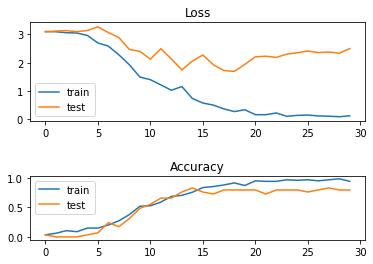

In [18]:
plot1 = plt.subplot2grid((2, 1), (0, 0), colspan=1)
plot2 = plt.subplot2grid((3, 1), (2, 0), colspan=2)


# plot loss during training
plot1.set_title('Loss')
plot1.plot(history.history['loss'], label='train')
plot1.plot(history.history['val_loss'], label='test')
plot1.legend()



# plot accuracy during training
plot2.set_title('Accuracy')
plot2.plot(history.history['accuracy'], label='train')
plot2.plot(history.history['val_accuracy'], label='test')
plot2.legend()

In [19]:
acc2 = model2.evaluate(X_test,y_test)[1]

print(" The accuracy of the model two is", acc2)

list_acc.append(acc2)

1/1 [==============================] - 0s 28ms/step - loss: 2.5008 - accuracy: 0.7931
 The accuracy of the model two is 0.7931034564971924


## Choix du modèle

In [20]:
print("Le meilleur modèle est le", list_acc.index(max(list_acc))+1)


Le meilleur modèle est le 2


In [21]:
if list_acc.index(max(list_acc))+1 == 1:
    model = model1
else : 
    model = model2

In [22]:
# to save the trained model
model.save("chat_model")



# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(label_enc, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

2022-05-04 19:25:37.390689: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: chat_model/assets


INFO:tensorflow:Assets written to: chat_model/assets


## Mise en production

In [ ]:

with open("data.json") as file:
    data = json.load(file)


def chat():
    # load trained model
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20
    
    while True:
        print( "User: ",end="")
        inp = input()
        if inp.lower() == "exit":
            break

            
        ## We make sure to apply the exact same preprocessing 
        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])

        for i in data['intents']:
            if i['intent'] == tag:
                
                ## We choose random answers from the database
                print("ChatBot:", np.random.choice(i['responses']))


print("Start talking to the chatbot, type 'exit' to end conversation:")
chat()

Start talking to the chatbot, type 'exit' to end conversation:
User: Hi
ChatBot: Hola human, please tell me your GeniSys user
User: What is your name?
ChatBot: You can call me Geni
User: And you real name?
ChatBot: My real name is GeniSys
User: Do you have time,
ChatBot: One sec
User: Thanks
ChatBot: My pleasure
User: Tell me a joke
ChatBot: A man visits his doctor: 'Doc, I think I'm losing it', he says',I'm forever dreaming I wrote Lord Of The Rings.' 'Hmm. One moment', replies the doctor, consulting his medical book. 'Ah yes, now I see... you've been Tolkien in your sleep.'
User: Haha, bye bye!
ChatBot: Not a problem! Have a nice day
User: 